In [1]:
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt 
import json
import numpy as np
import pandas as pd
import copy
from Metrics import getSentiment, getQuoteBased, getSensationalized, getMudslinging, getSpin, getInformal
from Clustering import ClusterMetrics, getBestLabels, getBestDistance

In [2]:
print('Loading File')
file = open('rust-articles-backup.json', encoding='utf8')
articles = pd.DataFrame.from_dict(json.load(file))
print('File Loaded')

Loading File
File Loaded


-1 means that it isn't clustered as a group

In [3]:
X = np.array([[1, 2], [2, 2], [2, 3], [8, 7], [8, 8], [25, 80], [100,100]])
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
clustering.labels_

array([ 0,  0,  0,  1,  1, -1, -1], dtype=int64)

In [4]:
# max_dist works for 0.4-1.1
metrics = np.array(
    [
        [0.9,-0.4], # positive, opinion
        [0.6,-0.3], # positive, opinion
        [0.1,0.7], # neutral, factual
        [-0.2,0.8], # neutral, factual
        [-0.9,-0.8], # negative, opinion
        [-0.6,-0.6], # negative, opinion
    ]
)
labels = ClusterMetrics(metrics)
print(labels)

[0 0 1 1 2 2]


In [5]:
metrics = []
sentiments = []
quoteBaseds = []
for i in range(1000):
    sentiment = getSentiment(articles.at[i,'body'])
    quoteBased = getQuoteBased(articles.at[i,'body'])
    sentiments.append(sentiment)
    quoteBaseds.append(quoteBased)
    metrics.append([sentiment, quoteBased])
print(metrics)

[[0.30910000000000004, 0.51423], [0.5386, 0.16694], [0.986, 1], [0.0033500000000000196, 0.40527], [0.9777, 0.27697], [0.07579999999999998, 0.08282], [0.99585, 0.10471], [0.99585, 0.10468], [0.60015, 0.31558], [0.9983500000000001, 0.41131], [0.009000000000000008, 0.39148], [0.03770000000000001, 0.09973], [0.30910000000000004, 0.0], [0.96845, 0.72513], [0.5, 0.0], [0.035650000000000015, 0.40544], [0.0048000000000000265, 0.20576], [0.008649999999999991, 0.07456], [0.9923500000000001, 0.13839], [0.21355000000000002, 0.31351], [0.4751, 0.22599], [0.9061, 0.0], [0.003149999999999986, 0.27488], [0.01629999999999998, 0.27567], [0.017349999999999977, 0.0], [0.13245, 0.17039], [0.011699999999999988, 0.2476], [0.08875, 0.0], [0.002950000000000008, 0.21488], [0.9721, 0.37209], [0.99915, 0.19406], [0.9904, 0.16796], [0.99125, 0.36376], [0.04744999999999999, 0.25635], [0.584, 0.29743], [0.9984999999999999, 0.3074], [0.48215, 0.58855], [0.98785, 0.41344], [0.0027499999999999747, 0.56143], [0.99740000

Gets best cluster distance

In [6]:
max = 0
maxDist = 0
dist = 0.01
while dist <= 1:
    labels = ClusterMetrics(metrics,dist,10)
    labelsCount = len(set(labels))
    withGroup = 1 - (np.count_nonzero(labels == -1) / len(labels))
    maximizeValue = withGroup * labelsCount # Trying to maximize the number of groups and minimize the number of articles without a group
    if maximizeValue > max:
        maxDist = dist
        max = maximizeValue
    dist = round(dist + 0.01,3)

print(10,maxDist)

labels = ClusterMetrics(metrics,maxDist,10)
labelsCount = len(set(labels))
print(labelsCount)
print(np.count_nonzero(labels == -1))

10 0.08
5
76


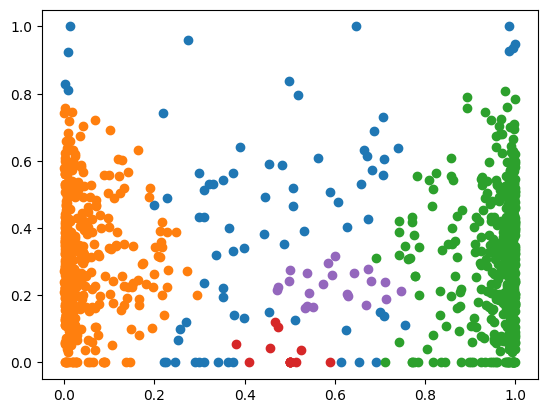

In [7]:
for i in range(labelsCount):
    i = i - 1
    x = []
    y = []
    for j in range(len(labels)):
        if labels[j] == i:
            x.append(sentiments[j])
            y.append(quoteBaseds[j])
    plt.scatter(x,y) 
plt.show()

---

In [8]:
print("Loading File")
file = open("rust-articles-backup-metrics.json", encoding="utf8")
metricArticles = pd.DataFrame.from_dict(json.load(file))
print("File Loaded")

Loading File
File Loaded


In [9]:
metrics = []
sentiments = []
quoteBaseds = []
for i in range(len(metricArticles)):
    sentiment = metricArticles.iloc[i]['sentiment']
    quoteBased = metricArticles.iloc[i]['quoteBased']
    sensationalized = metricArticles.iloc[i]['sensationalized']
    mudslinging = metricArticles.iloc[i]['mudslinging']
    spin = metricArticles.iloc[i]['spin']
    informal = metricArticles.iloc[i]['informal']
    metrics.append([sentiment, quoteBased, sensationalized, mudslinging, spin, informal])

print(len(metrics))

161225


In [15]:
samples, dist = getBestDistance(metrics[:30000])
print(samples,dist)
labels = ClusterMetrics(metrics[:30000],dist,samples) # Run out of memory if do all data
print(len(set(labels)))
print((1 - (np.count_nonzero(labels == -1) / len(labels))))

7 0.09
3
0.9597333333333333


In [16]:
from collections import Counter
print(Counter(labels))
print(labels)
for i in range(len(labels)):
    metricArticles.loc[str(i),'label'] = labels[i]
metricArticles.to_json('rust-articles-backup-metrics-labels-small.json')

Counter({0: 28781, -1: 1208, 1: 11})
[ 0 -1  0 ...  0  0  0]


---

In [17]:
labeledMetrics = copy.deepcopy(metrics[:len(labels)])
for i in range(len(labels)):
    labeledMetrics[i].append(labels[i])
labeledMetrics = pd.DataFrame(labeledMetrics,columns=['sentiment', 'quoteBased', 'sensationalized', 'mudslinging', 'spin', 'informal', 'label'])
meanMetrics = labeledMetrics.groupby(['label']).mean()
iqrMetrics = labeledMetrics.groupby(['label']).quantile(0.75) - labeledMetrics.groupby(['label']).quantile(0.25)

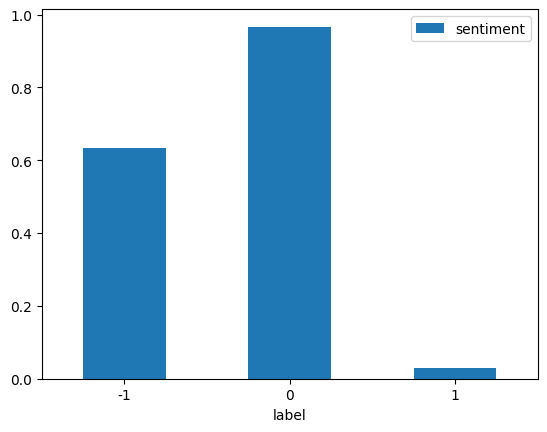

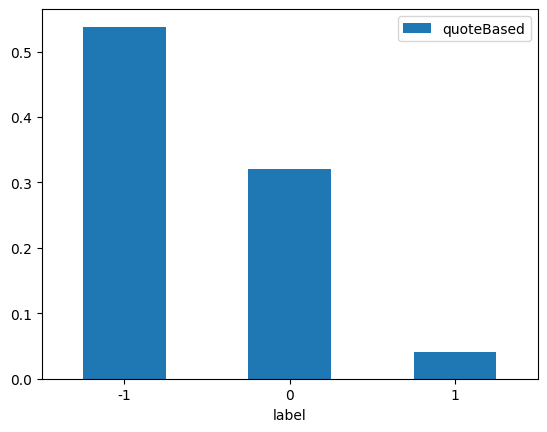

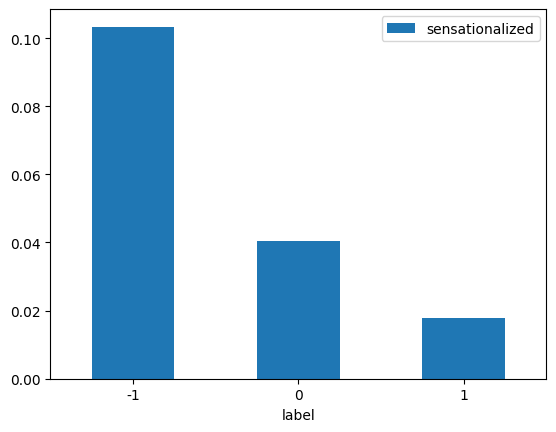

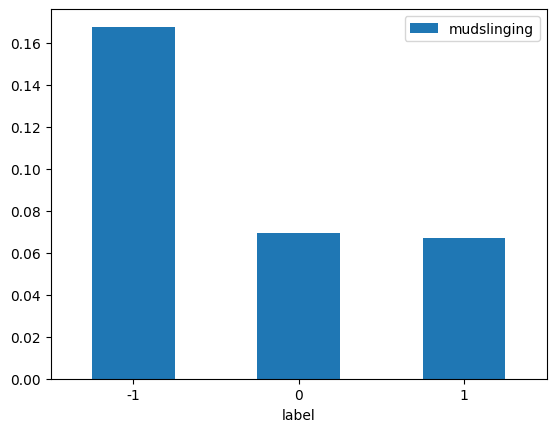

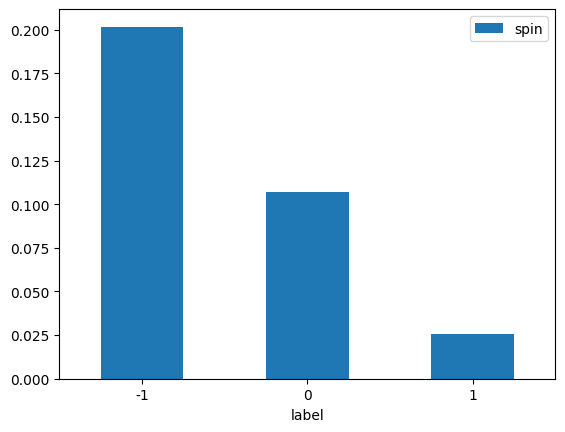

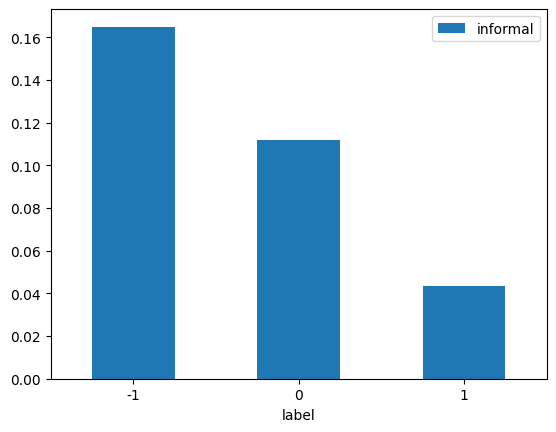

In [18]:
# IQR Graphs
sentimentGraph = iqrMetrics.plot.bar(y=['sentiment'], rot=0)
quoteBasedGraph = iqrMetrics.plot.bar(y=['quoteBased'], rot=0)
sensationalizedGraph = iqrMetrics.plot.bar(y=['sensationalized'], rot=0)
mudslingingGraph = iqrMetrics.plot.bar(y=['mudslinging'], rot=0)
spinGraph = iqrMetrics.plot.bar(y=['spin'], rot=0)
informalGraph = iqrMetrics.plot.bar(y=['informal'], rot=0)

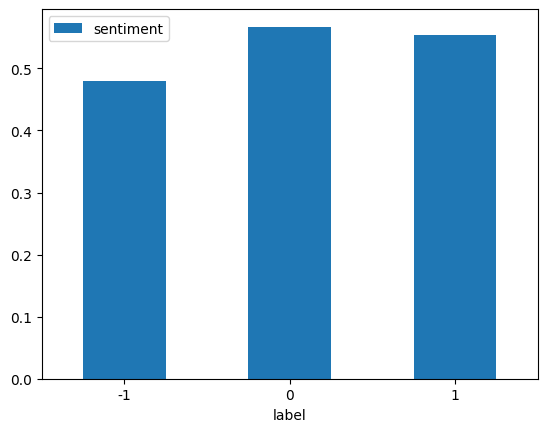

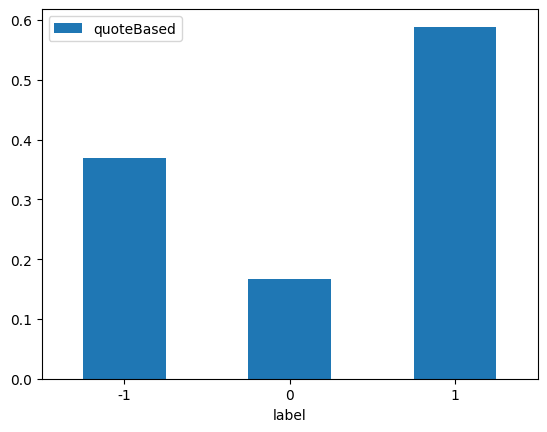

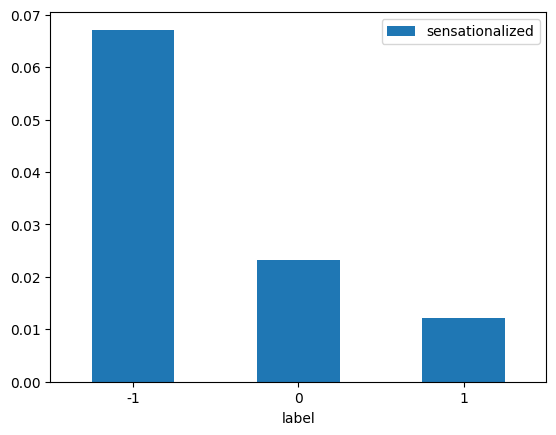

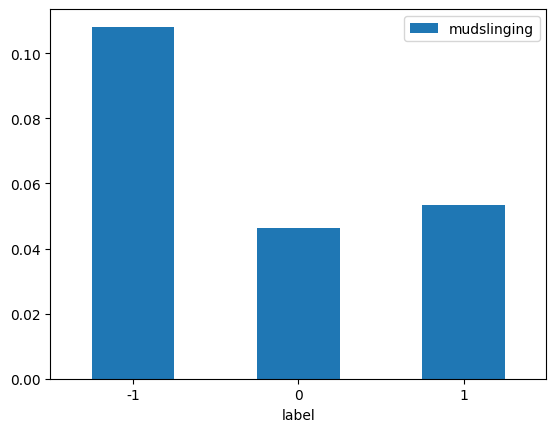

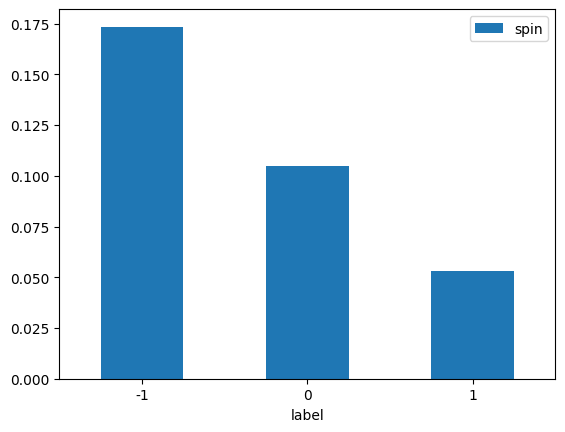

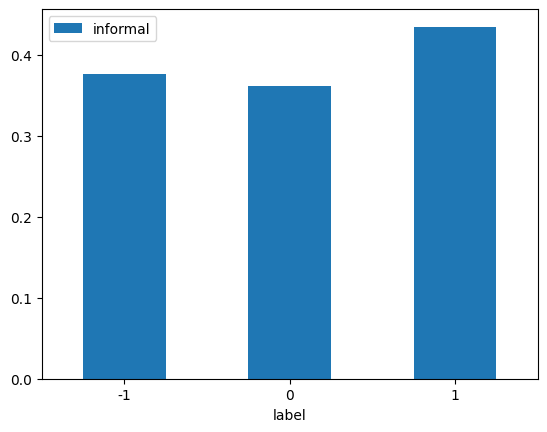

In [19]:
# Mean Graphs
sentimentGraph = meanMetrics.plot.bar(y=['sentiment'], rot=0)
quoteBasedGraph = meanMetrics.plot.bar(y=['quoteBased'], rot=0)
sensationalizedGraph = meanMetrics.plot.bar(y=['sensationalized'], rot=0)
mudslingingGraph = meanMetrics.plot.bar(y=['mudslinging'], rot=0)
spinGraph = meanMetrics.plot.bar(y=['spin'], rot=0)
informalGraph = meanMetrics.plot.bar(y=['informal'], rot=0)